In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd
from operator import itemgetter
import matplotlib.pyplot as plt
%pylab inline
import itertools

Populating the interactive namespace from numpy and matplotlib


## STRUCTURE

- set sub nodes ( by line at each station )
- set master nodes ( by station )
- link of sub nodes by train
- link of sub nodes by transfer
- link of sub nodes and master nodes by waiting time

### set sub nodes

In [2]:
#Get the station data -
ndata = pd.read_csv("sub_node")

In [3]:
#initialize the graph
#G.clear()
G = nx.MultiDiGraph(name='NYC Subway Network')

In [4]:
#add sub nodes and attributes
for i in range(0,len(ndata)):
    G.add_node(ndata.node_id[i],
               name = ndata.stop_name[i],
               line = ndata['train'][i],
               lat = ndata.stop_lat[i],
               lng = ndata.stop_lon[i],
               geo = (ndata.stop_lon[i],ndata.stop_lat[i]),
               stop_id = ndata.stop_id[i],
               master_node='No',
               master_node_id = ndata.master_node_id[i]
              )

In [5]:
#show the nodes in G
G.nodes(data=True)[:3]

[('625_4',
  {'geo': (-73.951070000000001, 40.785671999999998),
   'lat': 40.785671999999998,
   'line': '4',
   'lng': -73.951070000000001,
   'master_node': 'No',
   'master_node_id': '96 St_1',
   'name': '96 St',
   'stop_id': '625'}),
 ('D25_Q',
  {'geo': (-73.972367000000006, 40.677050000000001),
   'lat': 40.677050000000001,
   'line': 'Q',
   'lng': -73.972367000000006,
   'master_node': 'No',
   'master_node_id': '7 Av_1',
   'name': '7 Av',
   'stop_id': 'D25'}),
 ('625_6',
  {'geo': (-73.951070000000001, 40.785671999999998),
   'lat': 40.785671999999998,
   'line': '6',
   'lng': -73.951070000000001,
   'master_node': 'No',
   'master_node_id': '96 St_1',
   'name': '96 St',
   'stop_id': '625'})]

### set master nodes

In [6]:
#get the master node data and attributes
mdata = pd.read_csv("master_node")

In [7]:
mdata.head()

,Unnamed: 0,master_node_id,stop_name,stop_id
0,0,1 Av_0,1 Av,L06
1,1,103 St - Corona Plaza_0,103 St - Corona Plaza,706
2,2,103 St_0,103 St,119
3,3,103 St_1,103 St,624
4,4,103 St_2,103 St,A18


In [8]:
#add nodes and attributes
for i in range(0,len(mdata)):
    G.add_node(mdata.master_node_id[i],
               name = mdata.stop_name[i],
               master_node='Yes',
               stop_id = mdata.stop_id[i]
              )

In [9]:
G.nodes(data=True)[6:8]

[('138_5',
  {'geo': (-74.012187999999995, 40.711835000000001),
   'lat': 40.711835000000001,
   'line': '5',
   'lng': -74.012187999999995,
   'master_node': 'No',
   'master_node_id': 'Cortlandt St_0',
   'name': 'Cortlandt St',
   'stop_id': '138'}),
 ('Richmond Valley_0',
  {'master_node': 'Yes', 'name': 'Richmond Valley', 'stop_id': 'S13'})]

## link of sub nodes by train

In [10]:
## get edge data
edata = pd.read_csv('duration_7-10am_weekday')

In [11]:
edata.head(3)

,Unnamed: 0,from_stop_id,to_stop_id,train,duration,from_stop_name,from_stop_lat,from_stop_lon,to_stop_name,to_stop_lat,to_stop_lon,from_node,to_node
0,0,101S,103S,1,90.0,Van Cortlandt Park - 242 St,40.889248,-73.898583,238 St,40.884667,-73.900870,101_1,103_1
1,1,103N,101N,1,90.0,238 St,40.884667,-73.900870,Van Cortlandt Park - 242 St,40.889248,-73.898583,103_1,101_1
2,2,103S,104S,1,90.0,238 St,40.884667,-73.900870,231 St,40.878856,-73.904834,103_1,104_1


In [12]:
# #ADD THE EDGES and weighted - method 1
for i in range(0,len(edata.from_node)):
    G.add_edge(edata.from_node[i],edata.to_node[i], 
               weight = edata.duration[i],
               ## attributes
               train = edata.train[i],
               edge_type = 'train')
# # add weighted edges  - method 2
# e= zip(edata.from_node_id,edata.to_node_id,edata.duration)
# G.add_weighted_edges_from(e,train=edata.train)

In [13]:
G.edges(data= True)[:3]

[('136_1', '137_1', {'edge_type': 'train', 'train': '1', 'weight': 80.0}),
 ('136_1', '135_1', {'edge_type': 'train', 'train': '1', 'weight': 60.0}),
 ('138_1', '139_1', {'edge_type': 'train', 'train': '1', 'weight': 90.0})]

### link of sub nodes by transfer

In [14]:
#ADD TRANSFER WITHOUT SWIPE EDGES
tdata = pd.read_csv("transfer")
tdata.head(3)

,Unnamed: 0,from_stop_id,to_stop_id,min_transfer_time,from_stop,to_stop,from_train,to_train,from_node_id,to_node_id
0,0,101,101,180,Van Cortlandt Park - 242 St,Van Cortlandt Park - 242 St,1,1,101_1,101_1
1,1,103,103,180,238 St,238 St,1,1,103_1,103_1
2,2,104,104,180,231 St,231 St,1,1,104_1,104_1


In [15]:
## adding transfer
for i in range(len(tdata)):
    G.add_edge(tdata.from_node_id[i],tdata.to_node_id[i],
               weight = tdata.min_transfer_time[i],
               ## attributes
               from_train = tdata.from_train[i],
               to_train = tdata.to_train[i],
               edge_type = 'transfer')
    
# ## method 2- add self loop
# e2= zip(tdata.from_stop_id,tdata.to_stop_id,tdata.min_transfer_time)
# G.add_weighted_edges_from(e)

In [16]:
G.edges(data= True)[3:5]

[('136_1',
  '136_2',
  {'edge_type': 'transfer',
   'from_train': '1',
   'to_train': '2',
   'weight': 180}),
 ('136_1', '137_1', {'edge_type': 'train', 'train': '1', 'weight': 80.0})]

### link of sub nodes and master nodes by waiting time

In [17]:
# add waiting time
wdata = pd.read_csv("waiting")
wdata.head(3)

,Unnamed: 0,stop_id,train,stop_name,stop_lat,stop_lon,node_id,master_node_id,train_num,interval,waiting
0,0,101,1,Van Cortlandt Park - 242 St,40.889248,-73.898583,101_1,Van Cortlandt Park - 242 St_0,29.0,372.413793,186.206897
1,1,103,1,238 St,40.884667,-73.900870,103_1,238 St_0,33.0,327.272727,163.636364
2,2,104,1,231 St,40.878856,-73.904834,104_1,231 St_0,33.0,327.272727,163.636364


In [18]:
## adding waiting
for i in range(len(wdata)):
    G.add_edge(wdata.master_node_id[i],wdata.node_id[i],
               weight = wdata.waiting[i],
               ## attributes
               train = wdata.train[i],
               stop_id = wdata.stop_id[i],
               edge_type = 'waiting')
    
# ## method 2- add self loop
# e2= zip(tdata.from_stop_id,tdata.to_stop_id,tdata.min_transfer_time)
# G.add_weighted_edges_from(e)

In [19]:
## adding exit
for i in range(len(wdata)):
    G.add_edge(wdata.node_id[i],wdata.master_node_id[i],
               weight = 0,
               ## attributes
               train = wdata.train[i],
               stop_id = wdata.stop_id[i],
               edge_type = 'exit')
    

## Network Info

In [20]:
print nx.info(G)

Name: NYC Subway Network
Type: MultiDiGraph
Number of nodes: 1378
Number of edges: 5749
Average in degree:   4.1720
Average out degree:   4.1720


In [21]:
master = filter(lambda (n,attr):attr['master_node']=='Yes',G.nodes(data=True))
sub = filter(lambda (n,attr):attr['master_node']=='No',G.nodes(data=True))
print 'number of master nodes:', len(master)
print 'number of sub nodes:', len(sub)

number of master nodes: 465
number of sub nodes: 913


In [22]:
nyc = gpd.read_file('../data/shapefile/nyc_borough_boundry_17b/nybb.shp').to_crs(epsg=4326)

In [23]:
## filter out edges by train and transfer
edges=[]
for (n1,n2,attr) in G.edges(data=True):
    if attr['edge_type'] in ['transfer','train']:
        edges.append((n1,n2))

In [24]:
edges[:4]

[('136_2', '136_2'),
 ('136_2', '136_1'),
 ('136_2', '136_5'),
 ('136_1', '136_2')]

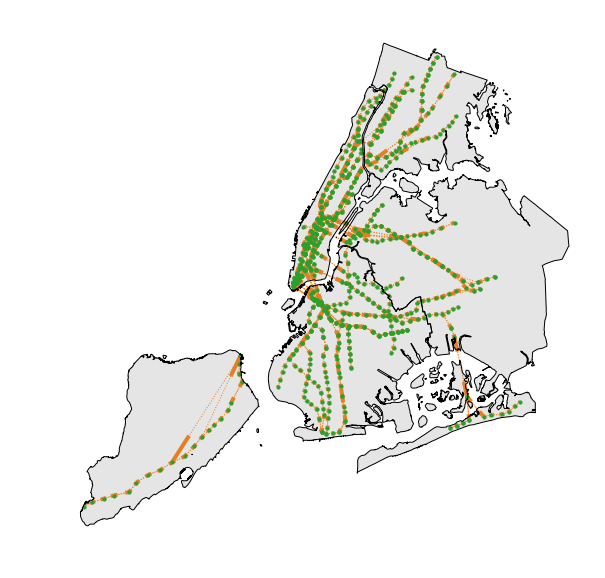

In [25]:
## only plot sub nodes, and edges between sub nodes
plt.figure(figsize=(10,10))
ax= plt.subplot()
nyc.plot(ax=ax,color= 'grey',alpha=0.2)

## filter out sub nodes
sub = filter(lambda (n,attr):attr['master_node']=='No',G.nodes(data=True))

## filter out edges only by transfer and train
edges=[]
for (n1,n2,attr) in G.edges(data=True):
    if attr['edge_type'] in ['transfer','train']:
        edges.append((n1,n2))

location = nx.get_node_attributes(G,'geo')
plt.axis("off")
nx.draw_networkx(G,
                 pos = location,
                 nodelist= map(lambda x:x[0],sub),
                 edgelist = edges,
                 with_labels =False,
                 node_size = 10,
                 style = 'dotted',
                 node_color= 'C2',
                 edge_color= 'C1')

## Centrality

In [26]:
## top 10 betweenness centrallity nodes
sorted(nx.betweenness_centrality(G).items(),key=lambda x: x[1],reverse=True)[:10]

[('R31_N', 0.2531768988857659),
 ('Q01_N', 0.2395409996234279),
 ('R20_N', 0.23746081028835145),
 ('629_4', 0.14109034999004647),
 ('629_5', 0.13271034969466536),
 ('631_4', 0.1256745309016625),
 ('635_4', 0.1256217660366159),
 ('A46_A', 0.12414676918611825),
 ('A51_A', 0.12174139260721849),
 ('631_5', 0.12062206246907635)]

In [30]:
## top 10 betweenness centrallity nodes
important_nodes = sorted(nx.betweenness_centrality(G).items(),key=lambda x: x[1],reverse=True)[:10]
stop_id = map(lambda x: x[0],important_nodes)
stop_name = ndata[ndata['node_id'].isin(stop_id)]['stop_name'].values
print zip(stop_id,stop_name)

[('R31_N', '59 St'), ('Q01_N', 'Grand Central - 42 St'), ('R20_N', '14 St - Union Sq'), ('629_4', '59 St'), ('629_5', 'Grand Central - 42 St'), ('635_4', '14 St - Union Sq'), ('631_4', 'Nostrand Av'), ('A46_A', 'Canal St'), ('635_5', '14 St - Union Sq'), ('631_5', 'Atlantic Av - Barclays Ctr')]


In [31]:
def most_important(G, centrality='betweenness',length=10):
    """
    G is network graph
    centrality could be: betweenness, degree ,closeness
    length = 10 is to select top 10 nodes of highest centrality 
    """
    if centrality == 'betweenness':
        important_nodes = sorted(nx.betweenness_centrality(G).items(),key=lambda x: x[1],reverse=True)[:length]
    if centrality == 'degree':
        important_nodes = sorted(nx.degree_centrality(G).items(),key=lambda x: x[1],reverse=True)[:length]
    if centrality == 'closeness':
        important_nodes = sorted(nx.closeness_centrality(G).items(),key=lambda x: x[1],reverse=True)[:length]
    
    stop_id = map(lambda x: x[0],important_nodes)
    stop_name=[]
    for i in stop_id:
        stop_name.append(ndata[ndata['node_id']==i]['stop_name'].values[0])
        
    ## build up the new network, with only import nodes
    G_important= nx.MultiDiGraph(name='important nodes in NYC Subway Network')
    for i in range(0,length):
        G_important.add_node(stop_id[i],
               name = ndata[ndata['node_id']==stop_id[i]]['stop_name'].values,
               line = ndata[ndata['node_id']==stop_id[i]]['train'].values,
               lat = ndata[ndata['node_id']==stop_id[i]]['stop_lat'].values[0],
               lng = ndata[ndata['node_id']==stop_id[i]]['stop_lon'].values[0],
               geo = (ndata[ndata['node_id']==stop_id[i]]['stop_lon'].values[0],
                      ndata[ndata['node_id']==stop_id[i]]['stop_lat'].values[0])
              )
    # plot the important nodes out
    
    ## base map of nyc
    plt.figure(figsize=(10,10))
    ax= plt.subplot()
    nyc.plot(ax=ax,color= 'grey',alpha=0.2)
    
    # NETWORK
    ## filter out sub nodes
    sub = filter(lambda (n,attr):attr['master_node']=='No',G.nodes(data=True))

    ## filter out edges only by transfer and train
    edges=[]
    for (n1,n2,attr) in G.edges(data=True):
        if attr['edge_type'] in ['transfer','train']:
            edges.append((n1,n2))

    location = nx.get_node_attributes(G,'geo')
    plt.axis("off")
    nx.draw_networkx(G,
                 pos = location,
                 nodelist= map(lambda x:x[0],sub),
                 edgelist = edges,
                 with_labels =False,
                 node_size = 10,
                 style = 'dotted',
                 node_color= 'C2',
                 edge_color= 'C1')
    
    ## the important nodes
    location_I = nx.get_node_attributes(G_important,'geo')
    nx.draw_networkx(G_important,
                 pos = location_I,
                 with_labels =False,
                 node_size = 40,
                 style = 'dotted',
                 node_color= 'C3',
                 edge_color= 'C1',
                 alpha=0.8)
    
    return zip(range(1,length+1),stop_name,stop_id)

[(1, 'Atlantic Av - Barclays Ctr', 'R31_N'),
 (2, 'Canal St', 'Q01_N'),
 (3, '14 St - Union Sq', 'R20_N'),
 (4, '59 St', '629_4'),
 (5, '59 St', '629_5')]

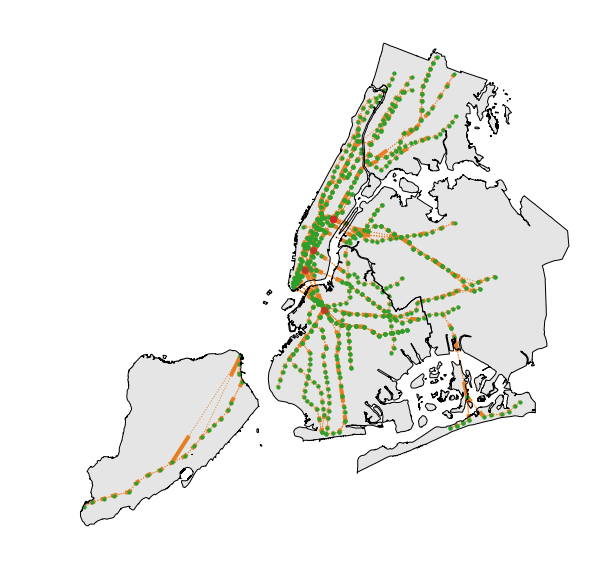

In [32]:
most_important(G,'betweenness',5)

In [ ]:
most_important(G,'closeness',5)

In [ ]:
most_important(G,'degree',5)

## Dijkstra-- Shortest Path

In [27]:
master_nodes = map(lambda x: x[0], master)

In [28]:
from_master=[]
to_master = []
for i,j in itertools.permutations(master_nodes,2):
    from_master.append(i)
    to_master.append(j)

In [29]:
whole_network = pd.DataFrame(zip(from_master,to_master),columns=['from_master','to_master'])

In [30]:
whole_network['shortest_path']= None
whole_network['duration']= None

In [ ]:
nopath=[]
#for i in range(10):
for i in range(len(whole_network)):
    from_master_id = whole_network.loc[i,'from_master']
    to_master_id = whole_network.loc[i,'to_master']
    try:
        shortest_path = ','.join(nx.shortest_path(G,from_master_id,to_master_id,weight= 'weight'))
        duration = nx.shortest_path_length(G,from_master_id,to_master_id,weight='weight')
        whole_network.loc[i,'shortest_path']= shortest_path
        whole_network.loc[i,'duration']= duration
        
    except:
        nopath.append((from_master_id,to_master_id))

In [ ]:
def 

In [34]:
whole_network

,from_master,to_master,shortest_path,duration
0,Grant Av_0,Atlantic Av - Barclays Ctr_0,"Grant Av_0,A57_A,A55_A,A51_A,A48_A,A46_A,A42_A...",1935.62
1,Grant Av_0,Richmond Valley_0,None,None
2,Grant Av_0,169 St_0,"Grant Av_0,A57_A,A55_A,A51_A,J27_J,J24_J,J23_J...",3410.69
3,Grant Av_0,Neptune Av_0,"Grant Av_0,A57_A,A55_A,A51_A,A48_A,A48_C,A47_C...",3397.05
4,Grant Av_0,Jamaica - 179 St_0,"Grant Av_0,A57_A,A55_A,A51_A,J27_J,J24_J,J23_J...",3635.69
5,Grant Av_0,Bedford Av_0,"Grant Av_0,A57_A,A55_A,A51_A,Broadway Jct_0,L2...",2002.05
6,Grant Av_0,63 Dr - Rego Park_0,"Grant Av_0,A57_A,A55_A,A51_A,J27_J,J24_J,J23_J...",3350.69
7,Grant Av_0,Junction Blvd_0,"Grant Av_0,A57_A,A55_A,A51_A,Broadway Jct_0,L2...",3511.05
8,Grant Av_0,40 St_0,"Grant Av_0,A57_A,A55_A,A51_A,Broadway Jct_0,L2...",2918.65
9,Grant Av_0,Montrose Av_0,"Grant Av_0,A57_A,A55_A,A51_A,Broadway Jct_0,L2...",1672.05
